In [60]:
##############################
# Author: Jacob van de Lindt
# Date:   May 22, 2023
# MIT PSFC
##############################

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cbook as cbook
from matplotlib import cm
from matplotlib import ticker, cm 
import os, sys
import netCDF4

In [61]:
# Setting up the paths to the local directory
# abspath = os.path.abspath('')
# dname = os.path.dirname(abspath)
# print(abspath)
# os.chdir(dname)
wkdir = os.getcwdb()

In [62]:
# Loading up the netcdf4 datasets
remoteDirectory = open(f'../../../remoteDirectory.txt', 'r').readlines()[0].strip()
shotNum = remoteDirectory.split('/')[-1].split('_')[1]

# 10 MW 
cql_nc_10 = netCDF4.Dataset(f'cql3d_bmpwr_10.nc','r')
cqlrf_nc_10 = netCDF4.Dataset(f'cql3d_krf_bmpwr_10.nc','r')

In [63]:
# Get particle properties, for now assume they all have same mesh points 
rya10 = cql_nc_10.variables["rya"][:]


# they are the same. Set a variable that is not dependent on beam energy. 
rya = rya10

#pitch angles mesh at which f is defined in radians.
#Note that np.ma.getdata pulls data through mask which
# rejects bad data (NAN, etc)

pitchAngleMesh10 = np.ma.getdata(cql_nc_10.variables["y"][:])

# all are equal. set just one pitch angle mesh 
pitchAngleMesh = pitchAngleMesh10


#normalized speed mesh of f
normalizedVel10 = cql_nc_10.variables["x"][:]

# independent of beam energy. Set one value 
normalizedVel = normalizedVel10


#print(normalizedVel.shape)

#energy  = restmkev*(gamma-1)
#energies corresponding to velocities jx

enerkev10 = cql_nc_10.variables["enerkev"][:] 

# these are also all the same. 

enerkev = enerkev10


#flux surface average energy per particle in keV 
energy10 = cql_nc_10.variables["energy"][:] #(tdim, r0dim, species_dim)

# so for example, energy[0, 0] gets an array at time zero and r[0] that is filled with 
# one energy for a species i. Note that we can have both maxwellian
# and general for each species
print(enerkev.shape)
print(energy10.shape)
print(energy10[0, 0])
print(energy10[100, 0])

print('CHECK THAT THESE MESHES ARE GOOD TO USE')
print('CHECKED. All meshes are identical, but the energy array differs')

(500,)
(201, 65, 5)
[10.86894315 10.26647201 10.874933   10.874933   10.27389462]
[21.01765659 10.27806798 10.874933   10.874933   10.27389462]
CHECK THAT THESE MESHES ARE GOOD TO USE
CHECKED. All meshes are identical, but the energy array differs


(2, 65, 500, 240)
(500,)


<ipython-input-64-4b88234a04a0>:31: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pc = ax.pcolormesh(VPARA, VPERP, np.log(f_at_rho.T + 1))#np.log(f_at_rho.T+1))


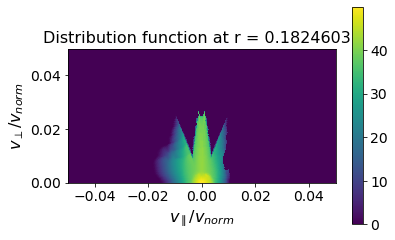

12


In [64]:
# distrobution function 
#distribution function (lrz, jx, iy)
#vnorm^3*s^3/cm^6
f10 = cql_nc_10.variables["f"][:]
f = f10
cql_nc = cql_nc_10
ebkev = 80 # kev TODO: make sure this matches the file!! 

print(f.shape)
print(enerkev.shape)

## Plot the distrobution function at a particular rho
rho = 0.1829 #0.25
i_rho = np.argmin(np.abs(rho - rya))

f_at_rho = f[0, i_rho, :, :]#f[0, i_rho, :, :]

pitchAngles = pitchAngleMesh[i_rho,:]
x = cql_nc.variables["x"][:]

V, Theta = np.meshgrid(x, pitchAngles)
VPARA = V*np.cos(Theta); VPERP = V*np.sin(Theta)

plt.rc('xtick', labelsize = 14)
plt.rc('ytick', labelsize = 14)
plt.rc('axes', labelsize = 16)
plt.rc('axes', titlesize = 16)
plt.rc('figure', titlesize = 18)
plt.rc('legend', fontsize = 14)
fig,ax = plt.subplots()
pc = ax.pcolormesh(VPARA, VPERP, np.log(f_at_rho.T + 1))#np.log(f_at_rho.T+1))
#ax.contourf(VPARA, VPERP, np.log(relevantF.T), cmap=cm.PuBu_r, levels = 100)
ax.set_aspect('equal')
ax.set_xlabel("$v_\parallel / v_{norm}$")
ax.set_ylabel("$v_\perp / v_{norm}$")
ax.set_ylim([0,0.05]); ax.set_xlim([-0.05,0.05])
ax.set_title(f'Distribution function at r = {rya[i_rho]}')
fig.colorbar(pc)
plt.show()
print(i_rho)

In [65]:
# Build the plot of energetic particles for a particular distrobution 

minEnergy = 2 # minimum energy for plotting

#index of that minimum energy in enerkev
#this index is also the index for the corresponding velocity
minEnergyIndex = np.where(enerkev < minEnergy)[0][-1]
#distribution function for energetic particles
energeticF = f[0, :,minEnergyIndex:,:]#f[0, :,minEnergyIndex:,:]

# begin integrating over velocity space 
energeticF_integOverPitch = np.zeros((len(rya), len(enerkev[minEnergyIndex:])))

# loop over r/a. At each r/a, integrate over all pitch angle. 
for rhoIndex in range(len(rya)):
    #this is the angular part of the spherical jacobian
    integOverPitch = 2*np.pi*np.trapz(energeticF[rhoIndex,:]*np.sin(pitchAngleMesh[rhoIndex]), pitchAngleMesh[rhoIndex], axis = 1)
    energeticF_integOverPitch[rhoIndex,:] = integOverPitch
    
print('REMEBER: check you selected the correct f from above cell')

REMEBER: check you selected the correct f from above cell


In [66]:
relevantEnergies = enerkev[minEnergyIndex:]
relevantVels = normalizedVel[minEnergyIndex:]
energeticDensity = np.zeros((len(rya), len(relevantEnergies)-1))
#the energies at which the values of energeticDensity are centered
energyCenters = (relevantEnergies[1:] + relevantEnergies[:-1])/2
#We calculate energy centers by integrating up to the velocity mesh point on either side of the corresponding energyCenter point
#we then take the differences, which is the area in the bin between these two edges
for velIndex in range(len(relevantVels)-1):
    #this is the radial part of the spherical jacobian
    densityLower = np.ma.getdata(np.trapz(energeticF_integOverPitch[:,:velIndex]*relevantVels[:velIndex]**2,
        relevantVels[:velIndex]))
    densityUpper = np.ma.getdata(np.trapz(energeticF_integOverPitch[:,:velIndex+1]*relevantVels[:velIndex+1]**2,
        relevantVels[:velIndex+1]))

    if velIndex == 0:
        energeticDensity[:,velIndex] = densityUpper
        continue

    diff = densityUpper - densityLower

    energeticDensity[:,velIndex] = diff

energeticDensity = energeticDensity*1e6#convert to m^(-3)
energeticDensity = energeticDensity.astype('float64')
rya = rya.astype('float64')



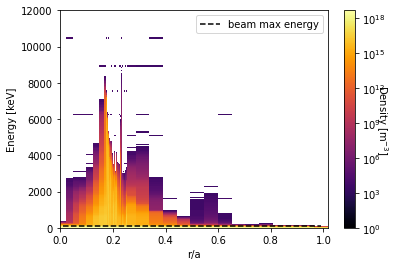

In [67]:
plt.rc('xtick', labelsize = 10)
plt.rc('ytick', labelsize = 10)
plt.rc('axes', labelsize = 10)
plt.rc('axes', titlesize = 10)
plt.rc('figure', titlesize = 10)
plt.rc('legend', fontsize = 10)
#"""
fig, ax = plt.subplots()
# pcm = ax.pcolormesh(energyCenters, rya, energeticDensity, 
#                 norm=colors.LogNorm(vmin=1, vmax=np.max(energeticDensity)),
#                 shading = 'nearest')
# print('---')
# print(rya.shape)
pcm = ax.pcolormesh(rya.T, energyCenters.T, energeticDensity.T
, 
                norm=colors.LogNorm(vmin=1, vmax=np.max(energeticDensity.T)),
                shading = 'nearest', cmap='inferno')

cbar = fig.colorbar(pcm, ax=ax)#, extend='max')
cbar.set_label(r'Density [m$^{-3}$]', rotation=270)
ax.set_ylim([0,12000])
plt.savefig('heatmap.png')
plt.plot(rya, (rya/rya)*ebkev, 'k--', label='beam max energy')
plt.xlabel('r/a')
plt.ylabel('Energy [keV]')
plt.legend()
plt.show()

In [68]:
dvol = cql_nc_10.variables['dvol'][:]
dvol10 = cql_nc_10.variables['dvol'][:]
print(np.array_equal(dvol, dvol10))

True


(65,)


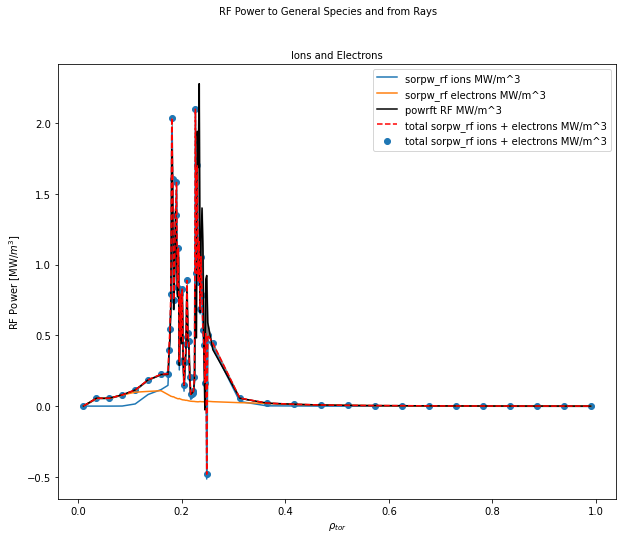

In [70]:
species_index = 0

fig, ax1 = plt.subplots()
fig.suptitle('RF Power to General Species and from Rays')
fig.set_size_inches(10, 8)


powers10 = cql_nc_10.variables['powers'][-1, species_index, :, :]


pwr_RF_to_gen10i = powers10[4, :]


ax1.plot(rya, pwr_RF_to_gen10i, label='sorpw_rf ions MW/m^3')
#ax1.set_xlim(.18, 0.185)
#ax1.set_ylim(0, 1.6)
ax1.legend()

ax1.set_xlabel(r'$\rho_{tor}$')
ax1.set_ylabel(r'RF Power [MW/$m^3$]')
ax1.set_title('Ions and Electrons')

species_index = 1

powers10 = cql_nc_10.variables['powers'][-1, species_index, :, :]


pwr_RF_to_gen10e = powers10[4, :]


ax1.plot(rya, pwr_RF_to_gen10e, label='sorpw_rf electrons MW/m^3')


# ax2.set_xlabel(r'$\rho_{tor}$')
# ax2.set_ylabel(r'RF Power [MW/$m^3$]')
# ax2.set_title('Electrons')


powrft = cql_nc_10.variables['powrft'][-1, :]
print(powrft.shape)

ax1.plot(rya, powrft, label='powrft RF MW/m^3', color='k')
ax1.plot(rya, pwr_RF_to_gen10i + pwr_RF_to_gen10e, label='total sorpw_rf ions + electrons MW/m^3', linestyle='--', color='red')
ax1.scatter(rya, pwr_RF_to_gen10i + pwr_RF_to_gen10e, label='total sorpw_rf ions + electrons MW/m^3')
ax1.legend()

plt.fill_between(rya, pwr_RF_to_gen10i + pwr_RF_to_gen10e, powrft, color='grey') 
#ax1.set_ylim(0, 2.4)
#plt.vlines(0.25, ymin= 0, ymax=1.4)
 

In [ ]:
def dens_e3(r, z):
    ne0 = 2.25e19
    ne1 = 2.0e18
    # get saved density profile on a uniformly spaced rho_tor mesh
    #genray_density = np.load('/home/vandelij/Desktop/HFS_HHFW_antenna/PetraM/genray_density.npy')
    ndens = genray_density.shape[0]
    genray_rho = np.linspace(0, 1, ndens)
    #genray_electron_density = interp1d(genray_rho, genray_density, kind='cubic')
    npsifit = interp2d_cubic(rgrid, zgrid, npsirz, r, z)
    rho_petraM = np.sqrt(npsifit)

    # if the rho coord is outside the LCFS, assign the minimum of the genray density array
    if rho_petraM > 0.99:
     #   return genray_density[-1]
        rho_LCFS = genray_rho[-1]
        # get the distance from the LCFS
        psi_falloff = 0.2
        falloff = exp(-( npsifit - 0.99)**2/ psi_falloff**2) 
        return falloff*rho_LCFS
    
    # else, iterpolate the density 
    else:
        #return genray_electron_density(rho_petraM)
        return interp1d_cubic(genray_rho, genray_density, rho_petraM)

0.8811941037055837
0.9366452225481391
0.8826663873217178
[0.23929487 0.24204327]
0.16
0.17333333
0.19257211
0.19532051


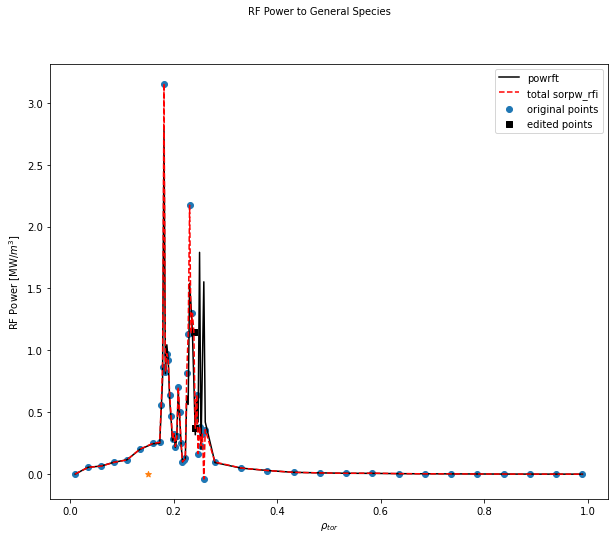

In [11]:
#now, checking if the integrated red dashed curve minus the intgrated black curve is equal to 
sorpw_rf_total = np.trapz((pwr_RF_to_gen10i + pwr_RF_to_gen10e)*dvol*(1/100)**3)
powrf_rf_total = np.trapz((powrft)*dvol*(1/100)**3)
print(sorpw_rf_total)
print(powrf_rf_total)

#Now, change three points: red dashed curve ion peaks get replaced by black curve peaks 
edited_sorpw = pwr_RF_to_gen10i + pwr_RF_to_gen10e
edited_sorpw[13] = powrft[13]
#edited_sorpw[32] = powrft[32]
# edited_sorpw[7] = powrft[7]
# edited_sorpw[8] = powrft[8]

integrated_edited_power = np.trapz((edited_sorpw)*dvol*(1/100)**3)
print(integrated_edited_power)

fig, ax1 = plt.subplots()
fig.suptitle('RF Power to General Species')
fig.set_size_inches(10, 8)
plt.plot(rya, powrft, color='k', label='powrft')
plt.plot(rya, edited_sorpw, 'r--', label='total sorpw_rfi')
plt.scatter(rya, edited_sorpw, label='original points')
plt.scatter(rya[31:33], edited_sorpw[31:33], marker='s', color='k', label='edited points')
ax1.set_xlabel(r'$\rho_{tor}$')
ax1.set_ylabel(r'RF Power [MW/$m^3$]')
plt.legend()
print(rya[31:33])
plt.scatter(0.15, 0, marker='*')
print(rya[6])
print(rya[7])
print(rya[14])
print(rya[15])


In [48]:
# old rya array
# rya(1)= 0.01 0.03882 0.06765 0.09647 0.12529 0.15412 0.18294 0.21176 0.24059 0.26941 0.29824 0.32706 0.35588 0.38471 0.41353 0.44235 0.47118 0.5 0.52882 0.55765 0.58647 0.61529 0.64412 0.67294 0.70176 0.73059 0.75941 0.78824 0.81706 0.84588 0.87471 0.90353 0.93235 0.96118 0.99

# lrz_new = 60
# rya_inner = np.linspace(0.01, 0.35, 45)
# rya_outer = np.linspace(0.351, 0.99, 15)

#TODO: This rmesh worked super well STAR
# lrz_new = 65
# rya_inner = np.linspace(0.01, 0.35, 50)
# rya_outer = np.linspace(0.351, 0.99, 15)
# rya_new = np.append(rya_inner, rya_outer)
# rya_new = np.array([rya_new])
# print(rya_new)
# np.savetxt('rya_new.txt', rya_new)

# smaller even mesh 
# lrz_new = 44
# rya_new = np.linspace(0.01, 0.99, 40)
# rya_new = np.insert(rya_new, 7, (rya_new[6] + rya_new[7])/2)
# rya_new = np.insert(rya_new, 8+1, (rya_new[7+1] + rya_new[8+1])/2)
# rya_new = np.insert(rya_new, 9+2, (rya_new[8+2] + rya_new[9+2])/2)
# rya_new = np.insert(rya_new, 10+3, (rya_new[9+3] + rya_new[10+3])/2)
# #rya_outer = np.linspace(0.351, 0.99, 15)
# #rya_new = np.append(rya_inner, rya_outer)
# #rya_new = np.array([rya_new])
# #print(rya_new)
# np.savetxt('rya_new.txt', rya_new)


# new mesh: smaller 
# lrz_new = 55
# rya_inner = np.linspace(0.01, 0.35, 40)
# rya_outer = np.linspace(0.351, 0.99, 15)
# rya_new = np.append(rya_inner, rya_outer)
# rya_new = np.array([rya_new])
# print(rya_new)
# np.savetxt('rya_new.txt', rya_new)

# This one is very bad 
# lrz_new = 65
# rya_inist = np.linspace(0.01, 0.15, 5)
# rya_inner = np.linspace(0.151, 0.35, 45)
# rya_outer = np.linspace(0.351, 0.99, 15)
# rya_new = np.append(rya_inner, rya_outer)
# rya_new = np.append(rya_inist, rya_new)
# rya_new = np.array([rya_new])
# print(rya_new)
# np.savetxt('rya_new.txt', rya_new)

# trying to add more ploints to interior region 
lrz_new = 65
rya_inist = np.linspace(0.01, 0.16, 7)
rya_inner = np.linspace(0.17333333, 0.25, 43)
rya_outer = np.linspace(0.26, 0.99, 15)
rya_new = np.append(rya_inner, rya_outer)
rya_new = np.append(rya_inist, rya_new)
rya_new = np.array([rya_new])
print(rya_new)
np.savetxt('rya_new.txt', rya_new)
#print(rya_new)
print(rya_new.shape)

[[0.01       0.035      0.06       0.085      0.11       0.135
  0.16       0.17333333 0.17515873 0.17698412 0.17880952 0.18063492
  0.18246031 0.18428571 0.18611111 0.18793651 0.1897619  0.1915873
  0.1934127  0.19523809 0.19706349 0.19888889 0.20071428 0.20253968
  0.20436508 0.20619047 0.20801587 0.20984127 0.21166667 0.21349206
  0.21531746 0.21714286 0.21896825 0.22079365 0.22261905 0.22444444
  0.22626984 0.22809524 0.22992063 0.23174603 0.23357143 0.23539682
  0.23722222 0.23904762 0.24087302 0.24269841 0.24452381 0.24634921
  0.2481746  0.25       0.26       0.31214286 0.36428571 0.41642857
  0.46857143 0.52071429 0.57285714 0.625      0.67714286 0.72928571
  0.78142857 0.83357143 0.88571429 0.93785714 0.99      ]]
(1, 65)


(44,)


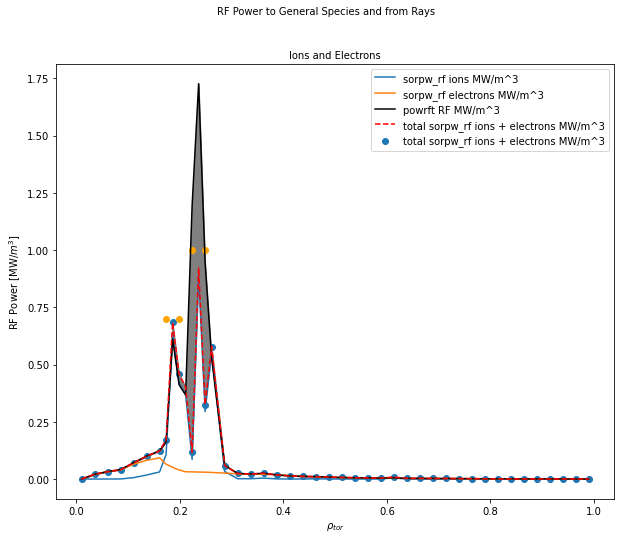

In [176]:
species_index = 0

fig, ax1 = plt.subplots()
fig.suptitle('RF Power to General Species and from Rays')
fig.set_size_inches(10, 8)


powers10 = cql_nc_10.variables['powers'][-1, species_index, :, :]


pwr_RF_to_gen10i = powers10[4, :]


ax1.plot(rya, pwr_RF_to_gen10i, label='sorpw_rf ions MW/m^3')
#ax1.set_xlim(.18, 0.185)
#ax1.set_ylim(0, 1.6)
ax1.legend()

ax1.set_xlabel(r'$\rho_{tor}$')
ax1.set_ylabel(r'RF Power [MW/$m^3$]')
ax1.set_title('Ions and Electrons')

species_index = 1

powers10 = cql_nc_10.variables['powers'][-1, species_index, :, :]


pwr_RF_to_gen10e = powers10[4, :]


ax1.plot(rya, pwr_RF_to_gen10e, label='sorpw_rf electrons MW/m^3')


# ax2.set_xlabel(r'$\rho_{tor}$')
# ax2.set_ylabel(r'RF Power [MW/$m^3$]')
# ax2.set_title('Electrons')


powrft = cql_nc_10.variables['powrft'][-1, :]
print(powrft.shape)

ax1.plot(rya, powrft, label='powrft RF MW/m^3', color='k')
ax1.plot(rya, pwr_RF_to_gen10i + pwr_RF_to_gen10e, label='total sorpw_rf ions + electrons MW/m^3', linestyle='--', color='red')
ax1.scatter(rya, pwr_RF_to_gen10i + pwr_RF_to_gen10e, label='total sorpw_rf ions + electrons MW/m^3')
ax1.legend()

plt.fill_between(rya, pwr_RF_to_gen10i + pwr_RF_to_gen10e, powrft, color='grey') 

plt.scatter(rya_new[7], .7, marker='o', color='orange')
plt.scatter(rya_new[9], .7, marker='o', color='orange')
plt.scatter(rya_new[11], 1, marker='o', color='orange')
plt.scatter(rya_new[13], 1, marker='o', color='orange')

In [101]:
# These cells are not relevant to the current study. 

# RF power to general species 
total_RF_power = np.array([0.0, 0.0, 0.0, 0.0, 0.0])
bmpwr_array = np.array([0, 2.5, 5, 7.5, 10])
print(np.trapz(pwr_RF_to_gen10*dvol*(1/100)**3))


total_RF_power[4] = np.trapz(pwr_RF_to_gen10*dvol*(1/100)**3)

print(total_RF_power)

plt.ylim((0, 1.1*max(total_RF_power)))
plt.plot(bmpwr_array, total_RF_power)
plt.title(f'Absorbed RF power on General Species (D) \n Maxwell Electrons Only')
plt.xlabel('Beam Power [MW]')
plt.ylabel('Absorbed RF Power [MW]')

NameError: name 'pwr_RF_to_gen10' is not defined

1.7836528927995705


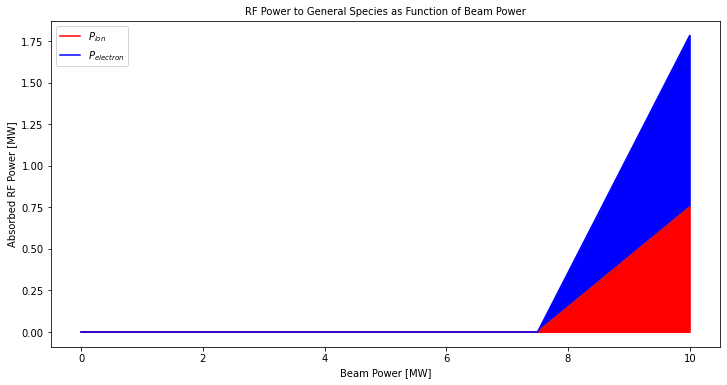

In [102]:
# Area to plot the power partition between species
total_RF_power_ion = np.array([0.0, 0.0, 0.0, 0.0, 0.0])
total_RF_power_e = np.array([0.0, 0.0, 0.0, 0.0, 0.0])

species_index = 0

pwr_RF_to_gen10_ion = cql_nc_10.variables['powers'][-1, species_index, :, :][4, :]

species_index = 1

pwr_RF_to_gen10_e = cql_nc_10.variables['powers'][-1, species_index, :, :][4, :]


total_RF_power_ion[4] = np.trapz(pwr_RF_to_gen10_ion*dvol*(1/100)**3)


total_RF_power_e[4] = np.trapz(pwr_RF_to_gen10_e*dvol*(1/100)**3)

total_RF_power_both = total_RF_power_ion + total_RF_power_e
fig, ax1 = plt.subplots(1, 1)
plt.title('RF Power to General Species as Function of Beam Power')
factor = 1.2
fig.set_size_inches(10*factor, 5*factor)
plt.plot(bmpwr_array, total_RF_power_ion)
#plt.plot(bmpwr_array, total_RF_power_e)
plt.plot(bmpwr_array, total_RF_power_ion, color='red', label=r'$P_{ion}$')
plt.plot(bmpwr_array, total_RF_power_both, color='blue', label=r'$P_{electron}$')
plt.xlabel('Beam Power [MW]')
plt.ylabel('Absorbed RF Power [MW]')
plt.legend()
#plt.ylim(0, 1)

plt.fill_between(bmpwr_array, total_RF_power_both, total_RF_power_ion, color='blue')
plt.fill_between(bmpwr_array, total_RF_power_both*0, total_RF_power_ion, color='red')

print(total_RF_power_both[-1])

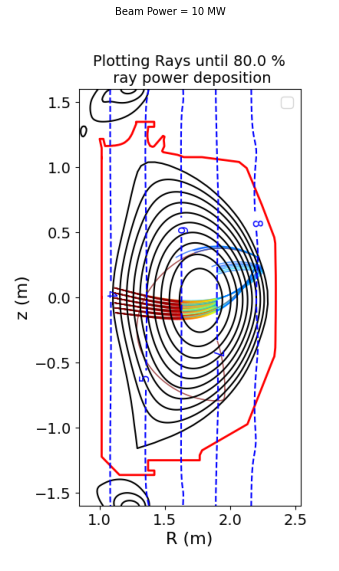

In [103]:
%matplotlib inline
plt.rc('figure', labelsize=52)
fig, ax1 = plt.subplots(1)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# ax1.imshow(mpimg.imread('rays_bmpwr0.png'))
# ax2.imshow(mpimg.imread('rays_bmpwr2_5.png'))
# ax3.imshow(mpimg.imread('rays_bmpwr5.png'))
# ax4.imshow(mpimg.imread('rays_bmpwr7_5.png'))
ax1.imshow(mpimg.imread('rays_bmpwr10.png'))
ax1.axis('off')


ax1.set_title('Beam Power = 10 MW')

fig.set_size_inches(10, 10)

plt.show()

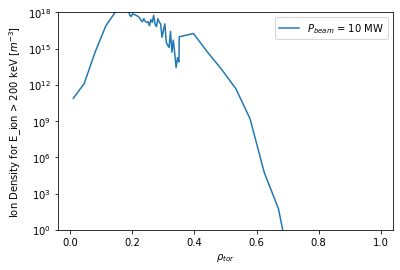

In [104]:
# plot the energetic particles over rho to easily compare between cases. 

def plot_energetic_ion_density_versus_rho(min_E, f, species_index, beam_label):
    minEnergy = 2 # minimum energy for plotting

    #index of that minimum energy in enerkev
    #this index is also the index for the corresponding velocity
    minEnergyIndex = np.where(enerkev < minEnergy)[0][-1]
    #distribution function for energetic particles (ions)
    energeticF = f[species_index, :,minEnergyIndex:,:]#f[0, :,minEnergyIndex:,:]

    # begin integrating over velocity space 
    energeticF_integOverPitch = np.zeros((len(rya), len(enerkev[minEnergyIndex:])))

    # loop over r/a. At each r/a, integrate over all pitch angle. 
    for rhoIndex in range(len(rya)):
        #this is the angular part of the spherical jacobian
        integOverPitch = 2*np.pi*np.trapz(energeticF[rhoIndex,:]*np.sin(pitchAngleMesh[rhoIndex]), pitchAngleMesh[rhoIndex], axis = 1)
        energeticF_integOverPitch[rhoIndex,:] = integOverPitch
        
    relevantEnergies = enerkev[minEnergyIndex:]
    relevantVels = normalizedVel[minEnergyIndex:]
    energeticDensity = np.zeros((len(rya), len(relevantEnergies)-1))
    #the energies at which the values of energeticDensity are centered
    energyCenters = (relevantEnergies[1:] + relevantEnergies[:-1])/2

    # Ion density versus r/a. Integrated over all energies. 

    energeticDensity_1D = np.zeros(len(rya))
    E_idx = np.argmin(np.abs(min_E - enerkev))

    #this is the radial part of the spherical jacobian
    energeticDensity_1D = np.ma.getdata(np.trapz(energeticF_integOverPitch[:,E_idx:]*relevantVels[E_idx:]**2,
        relevantVels[E_idx:]))

    energeticDensity_1D = energeticDensity_1D*1e6 # convert to m^-3
    plt.yscale('log')
    plt.ylim([1e0, 1e18])
    plt.plot(rya, energeticDensity_1D, label=beam_label)
    plt.xlabel(r'$\rho_{tor}$')
    plt.ylabel(f'Ion Density for E_ion > {min_E} keV' + r' [$m^{-3}$]')


# plot_energetic_ion_density_versus_rho(min_E=200, f=f0, species_index=0, beam_label=r'$P_{beam}$ = 0 MW')
# plot_energetic_ion_density_versus_rho(min_E=200, f=f2_5, species_index=0, beam_label=r'$P_{beam}$ = 2.5 MW')
# plot_energetic_ion_density_versus_rho(min_E=200, f=f5, species_index=0, beam_label=r'$P_{beam}$ = 5 MW')
# plot_energetic_ion_density_versus_rho(min_E=200, f=f7_5, species_index=0, beam_label=r'$P_{beam}$ = 7.5 MW')
plot_energetic_ion_density_versus_rho(min_E=200, f=f10, species_index=0, beam_label=r'$P_{beam}$ = 10 MW')

plt.legend()


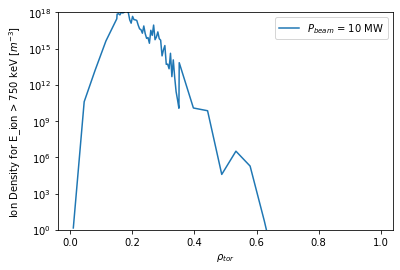

In [105]:
# plot_energetic_ion_density_versus_rho(min_E=750, f=f0, species_index=0, beam_label=r'$P_{beam}$ = 0 MW')
# plot_energetic_ion_density_versus_rho(min_E=750, f=f2_5, species_index=0, beam_label=r'$P_{beam}$ = 2.5 MW')
# plot_energetic_ion_density_versus_rho(min_E=750, f=f5, species_index=0, beam_label=r'$P_{beam}$ = 5 MW')
# plot_energetic_ion_density_versus_rho(min_E=750, f=f7_5, species_index=0, beam_label=r'$P_{beam}$ = 7.5 MW')
plot_energetic_ion_density_versus_rho(min_E=750, f=f10, species_index=0, beam_label=r'$P_{beam}$ = 10 MW')

plt.legend()

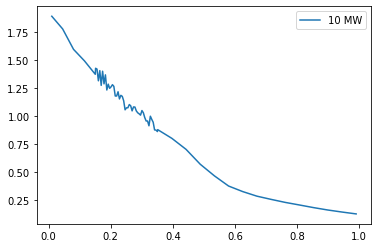

In [106]:
# NB power area 
species_index = 0
# powers0 = cql_nc_0.variables['powers'][-1, species_index, :, :]
# powers2_5 = cql_nc_2_5.variables['powers'][-1, species_index, :, :]
# powers5 = cql_nc_5.variables['powers'][-1, species_index, :, :]
# powers7_5 = cql_nc_7_5.variables['powers'][-1, species_index, :, :]
powers10 = cql_nc_10.variables['powers'][-1, species_index, :, :]
# pwr_beam_to_gen0 = powers0[5, :]
# pwr_beam_to_gen2_5 = powers2_5[5, :]
# pwr_beam_to_gen5 = powers5[5, :]
# pwr_beam_to_gen7_5 = powers7_5[5, :]
pwr_beam_to_gen10 = powers10[5, :]

# plt.plot(rya, pwr_beam_to_gen0, label='0 MW')
# plt.plot(rya, pwr_beam_to_gen2_5, label='2.5 MW')
# plt.plot(rya, pwr_beam_to_gen5, label='5 MW')
# plt.plot(rya, pwr_beam_to_gen7_5, label='7.5 MW')
plt.plot(rya, pwr_beam_to_gen10, label='10 MW')
plt.legend()

In [107]:
# Beam power to general species 
total_beam_power = np.array([0.0, 0.0, 0.0, 0.0, 0.0])
bmpwr_array = np.array([0, 2.5, 5, 7.5, 10])
print(np.trapz(pwr_RF_to_gen10*dvol*(1/100)**3))

# total_beam_power[0] = np.trapz(pwr_beam_to_gen0*dvol*(1/100)**3)
# total_beam_power[1] = np.trapz(pwr_beam_to_gen2_5*dvol*(1/100)**3)
# total_beam_power[2] = np.trapz(pwr_beam_to_gen5*dvol*(1/100)**3)
# total_beam_power[3] = np.trapz(pwr_beam_to_gen7_5*dvol*(1/100)**3)
total_beam_power[4] = np.trapz(pwr_beam_to_gen10*dvol*(1/100)**3)

print(total_beam_power)

plt.ylim((0, 1.1*max(total_beam_power)))
plt.plot(bmpwr_array, total_beam_power)
plt.title(f'Absorbed Beam power on General Species (D) \n Maxwell Electrons Only')
plt.xlabel('Beam Power [MW]')
plt.ylabel('Absorbed RF Power [MW]')

NameError: name 'pwr_RF_to_gen10' is not defined

2


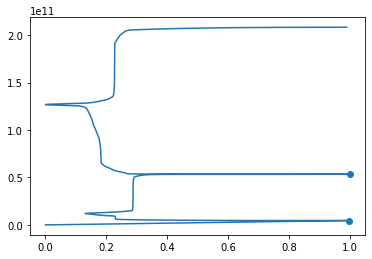

In [108]:
# delete this area. Just checking I am thinknig about these rays correctly. 
from scipy import signal
find_peaks = signal.find_peaks
radialVariable = (np.copy(cqlrf_nc_10.variables["spsi"]))
delpwr= np.copy(cqlrf_nc_10.variables["delpwr"])
bounceRho = .96 
ray = 1
peakIndices, _ = find_peaks(radialVariable[ray, :], height = bounceRho)
offset = 0
relevantIndices = peakIndices#[peakIndices > offset]

plt.plot(radialVariable[ray, :], delpwr[ray, :])
plt.scatter(radialVariable[ray, peakIndices], delpwr[ray, peakIndices])
print(len(relevantIndices))

In [109]:
# Calculate SPA for different beam powers 
from scipy import signal
find_peaks = signal.find_peaks
def getSPA(cqlrf_nc):
    """
    Finds single pass absorbtion using 
    1) energy at reflection point if ray is reflected
    2) assume all ray energy deposited if not reflected 
    Jacob fixed bug ignoring rays that did not reflect in SPA calculation 
    """
    radialVariable = (np.copy(cqlrf_nc.variables["spsi"]))
    delpwr= np.copy(cqlrf_nc.variables["delpwr"])


    #initialize SPA to zero. 
    averageSPA = 0
    bounceRho = .96  # if the ray turns after rho = 0.96, consider it reflected
   
    #fig,ax = plt.subplots()
    offset = 1     # reject turning points at eary times 
    ticker = 0
    for i in range(len(delpwr)):
        peakIndices, _ = find_peaks(radialVariable[i], height = bounceRho)
        relevantIndices = peakIndices[peakIndices > offset]
        
        #print(len(relevantIndices))
        if len(relevantIndices) >= 1:
            bounceIndex = relevantIndices[0]
            SPA = 1-delpwr[i][bounceIndex]/delpwr[i][0]
            averageSPA += SPA
            ticker = ticker + 1 
        elif len(relevantIndices) == 0:
            SPA = 1
            averageSPA += SPA
            #wr  = cqlrf_nc.variables["wr"][:] #major radius of the ray at each point along the trace
            #wz  = cqlrf_nc.variables["wz"][:]
            #plt.plot(wr[i, :], wz[i, :])
            #print(f'ray={i}')
            #break

    #print(f'ticker: {ticker}')  
    averageSPA /= len(delpwr)
    print(f"average SPA: {averageSPA}")
    print(f'% of rays reflected: {ticker*100/len(delpwr)} %')
    return averageSPA

In [110]:
SPA_array = np.array([0.0, 0.0, 0.0, 0.0, 0.0])

# SPA_array[0] = getSPA(cqlrf_nc_0)
# SPA_array[1] = getSPA(cqlrf_nc_2_5)
# SPA_array[2] = getSPA(cqlrf_nc_5)
# SPA_array[3] = getSPA(cqlrf_nc_7_5)
SPA_array[4] = getSPA(cqlrf_nc_10)

average SPA: 0.1808250948837575
% of rays reflected: 100.0 %


Text(0, 0.5, 'SPA for 1 MW RF')

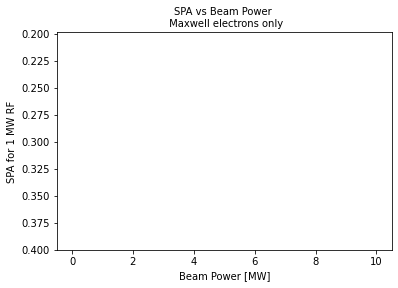

In [111]:
plt.ylim((0.4, 1.1*max(SPA_array)))
plt.plot(bmpwr_array, SPA_array)
plt.title(f'SPA vs Beam Power \n Maxwell electrons only')
plt.xlabel('Beam Power [MW]')
plt.ylabel('SPA for 1 MW RF')

FileNotFoundError: [Errno 2] No such file or directory: 'rays_bmpwr0.png'

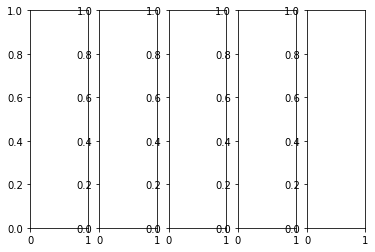

In [112]:
%matplotlib inline
import matplotlib
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#plt.rcParams.update({'font.size': 30})
ax1.imshow(mpimg.imread('rays_bmpwr0.png'))
ax2.imshow(mpimg.imread('rays_bmpwr2_5.png'))
ax3.imshow(mpimg.imread('rays_bmpwr5.png'))
ax4.imshow(mpimg.imread('rays_bmpwr7_5.png'))
ax5.imshow(mpimg.imread('rays_bmpwr10.png'))
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')
ax5.axis('off')

ax1.set_title(f'RF Power = 1 MW \n Beam Power: 0 MW \n SPA: {round(SPA_array[0], 3)}')
ax2.set_title(f'RF Power = 1 MW \n Beam Power: 2.5 MW \n SPA: {round(SPA_array[1], 3)}')
ax3.set_title(f'RF Power = 1 MW \n Beam Power: 5 MW \n SPA: {round(SPA_array[2], 3)}')
ax4.set_title(f'RF Power = 1 MW \n Beam Power: 7.5 MW \n SPA: {round(SPA_array[3], 3)}')
ax5.set_title(f'RF Power = 1 MW \n Beam Power: 10 MW \n SPA: {round(SPA_array[4], 3)}')

# ax1.set_title('Beam Power = 0 MW')
# ax2.set_title('Beam Power = 2.5 MW')
# ax3.set_title('Beam Power = 5 MW')
# ax4.set_title('Beam Power = 7.5 MW')
# ax5.set_title('Beam Power = 10 MW')

fig.set_size_inches(30, 30)

plt.show()

48
[111.34161569 111.43163638 111.50752572 ...          nan          nan
          nan]


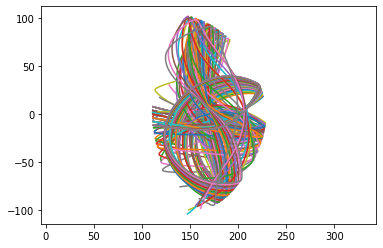

In [113]:
# Ray traces 

wr  = cqlrf_nc_10.variables["wr"][:] #major radius of the ray at each point along the trace
wz  = cqlrf_nc_10.variables["wz"][:]

# remove zero padding
wr[wr==0] = np.nan
wz[wr==0] = np.nan

print(len(wr))
for i_ray in range(len(wr)):
    plt.plot(wr[i_ray, :], wz[i_ray, :])

plt.axis('equal')
print(wr[1, -50000:])

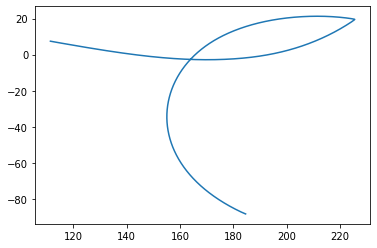

In [114]:
# Ray traces 

wr  = cqlrf_nc_10.variables["wr"][:] #major radius of the ray at each point along the trace
wz  = cqlrf_nc_10.variables["wz"][:]
# remove zero padding
wr[wr==0] = np.nan
wz[wr==0] = np.nan
ray = 1
plt.plot(wr[ray, :], wz[ray, :])